<a href="https://colab.research.google.com/github/KonstantinElfimow/svm-lab/blob/main/svm_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Распознавание образов с использованием SVM

## Задача

Воспользовавшись классификатором SVM, определите вероятности ошибок классификации линейно __неразделимых__ выборок двух классов для следующих типов ядер:
- RBF
- полиномиальная функция

Определите оптимальную функцию ядра.

## Решение

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.svm import SVC
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split,GridSearchCV, learning_curve,ShuffleSplit
from sklearn.metrics import accuracy_score, classification_report
from prettytable import PrettyTable

### Выборка

Cгенерируем линейно неразделимую выборку:

In [13]:
X,y = make_circles(n_samples=1000, noise=0.2, factor=0.25, random_state=17)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 17)

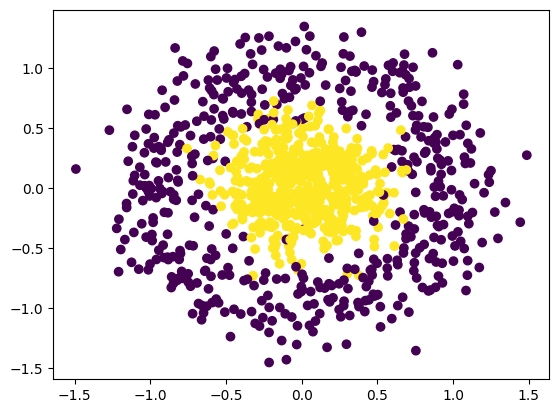

In [14]:
plt.scatter(X[:, 0], X[:, 1], c = y, cmap = 'viridis');

### Модель

#### Ядро

1. Полиномиальное ядро  
$$K(x,z) = (x^{T}z + c)^{p}$$

2. Радиальное ядро(RBF)
$$K(x,z) = exp(-\gamma\Vert{x-z}\Vert^{2})$$


In [15]:
kernels = ['linear','poly', 'rbf']
models  = []

Выполним обучение моделей с гиперпараметрами по умолчанию:
- __C__ = 1.0 - позволяет найти баланс между максимизацией разделяющей полосы и минимизацией суммарной ошибки;
когда С - маленький, классификатор допускает наличие ошибок при классификации(high bias, low variance);
когда С - большой, классификатор "наказывается" за допущенные ошибки(low bias, high variance).
- __degree__ = 3 - степень полинома(для полиномиального ядра)
- __gamma__ = 'auto'(1/n_features)

Посмотреть, как изменяются области принятия решений в зависимости от параметров можно <a href = "https://chrisalbon.com/machine-learning/svc_parameters_using_rbf_kernel.html">здесь</a>

In [16]:
t = PrettyTable(['Kernel','Train','Test'])
for kernel in kernels:
    clf = SVC(kernel=kernel)
    model = clf.fit(X_train,y_train)
    models.append(model)
    train_pred = clf.predict(X_train)
    test_pred = clf.predict(X_test)
    t.add_row([kernel, accuracy_score(y_train, train_pred), accuracy_score(y_test, test_pred)])
print(t)

+--------+--------------------+--------------------+
| Kernel |       Train        |        Test        |
+--------+--------------------+--------------------+
| linear | 0.6385714285714286 |        0.63        |
|  poly  | 0.5985714285714285 |        0.56        |
|  rbf   | 0.9557142857142857 | 0.9666666666666667 |
+--------+--------------------+--------------------+


Как можно видеть, без настройки с задачей классификации хорошо справляется только SVM с радиальным ядром.

### Поиск оптимального ядра

Для радиального ядра будем настраивать $\gamma$, а для полиномиального - степень $p$.

In [23]:
C = [0.001, 0.01, 0.1, 1, 10]
gamma = [0.001, 0.01, 0.1, 1, 10]
degree = np.arange(2)

In [24]:
tuned_parameters = [{'kernel': ['poly'], 'C': C, 'degree': degree},
                    {'kernel': ['rbf'], 'gamma': gamma,'C': C}]

In [26]:
from tqdm.notebook import tqdm
best_models = []
score = 'accuracy'
for t in tqdm(tuned_parameters):
    clf = GridSearchCV(SVC(random_state=17), t, cv=5, scoring='precision', n_jobs=-1)
    clf.fit(X_train, y_train)
    best_models.append(clf.best_estimator_)
    print("Лучшие параметры на обучающей выборке:")
    print(clf.best_params_)
    print("Отчет:")
    print("Модель обучена на всей обучающей выборке.")
    print("Оценки рассчитаны на тестовой выборке.")
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print('Процент ошибок на тестовой выборке: {0:.2f}%'.format((1 - accuracy_score(y_true, y_pred)) * 100))
    print()

  0%|          | 0/2 [00:00<?, ?it/s]

Лучшие параметры на обучающей выборке:
{'C': 10, 'degree': 1, 'kernel': 'poly'}
Отчет:
Модель обучена на всей обучающей выборке.
Оценки рассчитаны на тестовой выборке.
              precision    recall  f1-score   support

           0       0.76      0.41      0.53       152
           1       0.59      0.86      0.70       148

    accuracy                           0.63       300
   macro avg       0.67      0.64      0.61       300
weighted avg       0.67      0.63      0.61       300

Процент ошибок на тестовой выборке: 36.67%

Лучшие параметры на обучающей выборке:
{'C': 0.1, 'gamma': 10, 'kernel': 'rbf'}
Отчет:
Модель обучена на всей обучающей выборке.
Оценки рассчитаны на тестовой выборке.
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       152
           1       0.99      0.93      0.96       148

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.